# Training Protocols for Noisy Quantum Networks

In this notebook we demo how `qnetvo` can be used to train protocols in noisy quantum networks. The protocols include superdense coding, entanglement swapping, and teleportation. We draw upon known examples and applications that show how `qnetvo` is able to optimize the settings of quantum networks to perform various tasks. Furthermore, we show how variational optimization techniques can be used to train LOCC and LOQC protocols alike.

In [1]:
import pennylane as qml
import numpy as np
from pennylane import numpy as qnp
from scipy.stats import unitary_group
from matplotlib import pyplot as plt

import qnetvo

# Super Dense Coding

## Goal: Train a Superdense Coding Protocol


### 1.  Creating Network Nodes

In [2]:
# Arbitrary two-qubit pure state preparation
dense_coding_prep_nodes = [
    qnetvo.PrepareNode(
        wires=[0,1],
        ansatz_fn=qml.ArbitraryStatePreparation,
        num_settings=6,    
    )
]

# Alice's single-qubit unitary encoding
dense_coding_proc_nodes = [
    qnetvo.ProcessingNode(
        num_in=4,
        wires=[0],
        ansatz_fn=qml.ArbitraryUnitary,
        num_settings=3,
    )
]

# Bob's two-qubit measurement
dense_coding_meas_nodes = [
    qnetvo.MeasureNode(
        num_out=4,
        wires=[0,1],
        ansatz_fn=qml.ArbitraryUnitary,
        num_settings=15,
    )
]


### 2. Creating Network Ansatz

The super-dense coding ansatz circuit is constructed as three layers: prepare, processing, and measure.

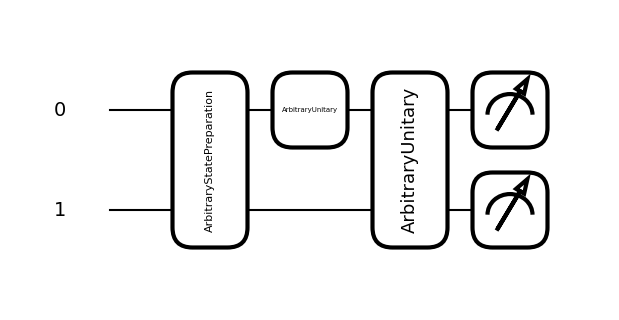

In [3]:
# construct ansatz circuit object
dense_coding_ansatz = qnetvo.NetworkAnsatz(
    dense_coding_prep_nodes,
    dense_coding_proc_nodes,
    dense_coding_meas_nodes,
)

# drawing the ansatz circuit to visualize
@qml.qnode(qml.device("default.qubit", wires=[0,1]))
def draw_circ():
    # 
    dense_coding_ansatz.fn(dense_coding_ansatz.zero_network_settings())
    return qml.probs(wires=[0,1])

qml.draw_mpl(draw_circ)();

### 3. Define Cost Function and Optimizing with Gradient Descent

Minimize the negative success probability $-P_{Success}$ over ansatz settings $\Theta $

$$
\min_{\Theta} Cost(\Theta) = - P_{Success}(\Theta)  = -\frac{1}{4}\sum_{x=0}^3 P(y=x|x, \Theta) = - \frac{1}{4}\sum_{x=0}^3 \textrm{Tr}\left[ \Pi^{A'B}_{y|\vec{\theta}}(U_{\vec{\gamma}_x}^A \otimes \mathbb{I}^B )|\psi^{AB}_{\vec{\phi}}\rangle \langle \psi^{AB}_{\vec{\phi}}|(U_{\vec{\gamma}_x}^A\otimes \mathbb{I}^B)^\dagger\right]
$$

where the settings $\Theta = \{\vec{\theta},\vec{\phi},\vec{\gamma}_0, \vec{\gamma}_1, \vec{\gamma}_2, \vec{\gamma}_3 \}$ parameterize the unitarys for state preparation, encoding, and measurement.

If the ansatz circuit's conditional probabilities $P(y|x)$ are arranged into a column stochastic matrix $\mathbf{P}(\Theta) = \sum_{x,y = 0}^3 P(y|x,\Theta) |y \rangle\langle x|$ then the cost is equivalent to $Cost(\Theta) = \textrm{Tr}[\mathbf{P}(\Theta)]$.

In [4]:
# construct the linear cost function
# the identity matrix encodes the trace operation
dense_coding_cost = qnetvo.linear_probs_cost_fn(dense_coding_ansatz, np.eye(4)/4)

dense_coding_opt_dict = qnetvo.gradient_descent(
    dense_coding_cost,
    dense_coding_ansatz.rand_network_settings(),
    verbose=True,
    sample_width=1,
    step_size=0.55,
    num_steps=80,
)


iteration :  0 , score :  0.20192474033455435
elapsed time :  0.1879258155822754
iteration :  1 , score :  0.23630055006586215
elapsed time :  0.18906807899475098
iteration :  2 , score :  0.2669163529738181
elapsed time :  0.2567930221557617
iteration :  3 , score :  0.29618413378119207
elapsed time :  0.16404223442077637
iteration :  4 , score :  0.3265505364495566
elapsed time :  0.16405916213989258
iteration :  5 , score :  0.35807695256286637
elapsed time :  0.163071870803833
iteration :  6 , score :  0.3882575994635904
elapsed time :  0.18510818481445312
iteration :  7 , score :  0.414094131277617
elapsed time :  0.2792630195617676
iteration :  8 , score :  0.4342684369151065
elapsed time :  0.1790769100189209
iteration :  9 , score :  0.44929766787075853
elapsed time :  0.1696789264678955
iteration :  10 , score :  0.4604088721057925
elapsed time :  0.1592860221862793
iteration :  11 , score :  0.46872505499393124
elapsed time :  0.21654200553894043
iteration :  12 , score :  0.

### 4. Adding Qubit Noise to Dense Coding Ansatz

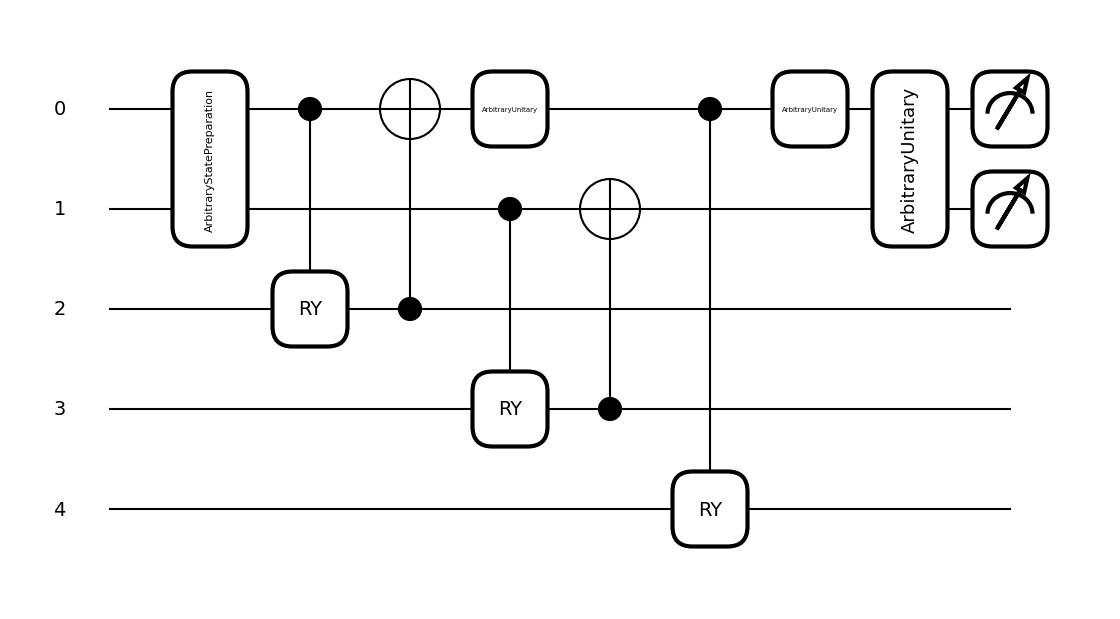

In [5]:

# nonuniform amplitude damping noise on each entangled state
qubit_amplitude_damping_nodes = [
    qnetvo.NoiseNode(wires=[0,2], ansatz_fn=lambda settings, wires: qnetvo.pure_amplitude_damping([0.3], wires=wires)), 
    qnetvo.NoiseNode(wires=[1,3], ansatz_fn=lambda settings, wires: qnetvo.pure_amplitude_damping([0.4], wires=wires)), 
]

# dephasing noise and rotation after the Alice's encoding
def dephasing_rot_noise(settings, wires):
    qnetvo.pure_phase_damping([0.3], wires=wires[0:2])
    qml.ArbitraryUnitary([0.5,0.6,0.7], wires=[wires[0]])

qubit_dephasing_noise_nodes = [
    qnetvo.NoiseNode(wires=[0,4], ansatz_fn=dephasing_rot_noise),
]

# construct noisy ansatz
noisy_dense_coding_ansatz = qnetvo.NetworkAnsatz(
    dense_coding_prep_nodes,
    qubit_amplitude_damping_nodes, # noise on state preparaation
    dense_coding_proc_nodes,
    qubit_dephasing_noise_nodes, # noise on communication
    dense_coding_meas_nodes,
)

#
@qml.qnode(qml.device("default.qubit", wires=[0,1,2,3]))
def draw_circ():
    noisy_dense_coding_ansatz.fn(noisy_dense_coding_ansatz.zero_network_settings())

    return qml.probs(wires=[0,1])

qml.draw_mpl(draw_circ)();

### 5. Optimizing Super-Dense Coding on a Noisy Network

In [6]:
# construct super-dense coding cost
noisy_dense_coding_cost = qnetvo.linear_probs_cost_fn(noisy_dense_coding_ansatz, np.eye(4)/4)

# optimize using gradient descent
noisy_opt_dict = qnetvo.gradient_descent(
    noisy_dense_coding_cost,
    noisy_dense_coding_ansatz.rand_network_settings(),
    verbose=True,
    sample_width=1,
    step_size=0.65,
    num_steps=80,
)


iteration :  0 , score :  0.34012728419708294
elapsed time :  0.22991180419921875
iteration :  1 , score :  0.3679426018153987
elapsed time :  0.2024240493774414
iteration :  2 , score :  0.39011704344079223
elapsed time :  0.5074911117553711
iteration :  3 , score :  0.40751212762727435
elapsed time :  0.7846789360046387
iteration :  4 , score :  0.4216021664416992
elapsed time :  0.2516031265258789
iteration :  5 , score :  0.4336936321158804
elapsed time :  0.21973299980163574
iteration :  6 , score :  0.4446500175814194
elapsed time :  0.4818439483642578
iteration :  7 , score :  0.4549305291460253
elapsed time :  0.206085205078125
iteration :  8 , score :  0.4647184180077719
elapsed time :  0.4967007637023926
iteration :  9 , score :  0.4740380501798148
elapsed time :  0.2820277214050293
iteration :  10 , score :  0.48283910481259085
elapsed time :  0.3471970558166504
iteration :  11 , score :  0.49105220642419145
elapsed time :  0.29969000816345215
iteration :  12 , score :  0.49

### 6. Comparing the Noisy and Noiseless Dense Coding Protocols

The super dense coding protocol can achieve perfect state discrimination fidelity in the noiseless case. In the noisy case, it $P_{Success}$ is just larger than the classical bound  $0.5 = P_{Success}$. Note that we find that the settings trained in the noiseless case perform worse in the presence of noise than when we trained the noisy protocol. This reflects the fact that our variational optimization methods train around the noise inherent to the network without needing to characterize the noise. That is, our protocol trained in the noisy setting performs better in the presence of noise than the protocol trained in the ideal setting.

Ideal State Discrimination Success :  0.9394832058145737
Noisy Protocol in ideal Setting :  0.7662776380257306
Noisy Protocol in Noisy Setting :  0.6626331886562998
Ideal Protocol in Noisy Settings :  0.5120598717705095


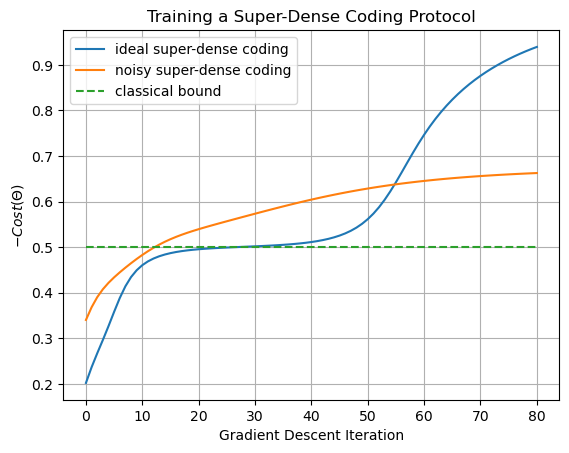

In [7]:
print("Ideal State Discrimination Success : ", dense_coding_opt_dict["opt_score"])
print("Noisy Protocol in ideal Setting : ", -dense_coding_cost(*noisy_opt_dict["opt_settings"]))
print("Noisy Protocol in Noisy Setting : ", noisy_opt_dict["opt_score"])
print("Ideal Protocol in Noisy Settings : ", -noisy_dense_coding_cost(*dense_coding_opt_dict["opt_settings"]))


plt.plot(range(len(dense_coding_opt_dict["scores"])), dense_coding_opt_dict["scores"], label="ideal super-dense coding")
plt.plot(range(len(noisy_opt_dict["scores"])), noisy_opt_dict["scores"], label="noisy super-dense coding")
plt.plot(range(len(noisy_opt_dict["scores"])), [0.5]*len(noisy_opt_dict["scores"]), "--", label="classical bound")
plt.grid()

plt.xlabel("Gradient Descent Iteration")
plt.ylabel(r"$-Cost(\Theta)$")
plt.legend()
plt.title("Training a Super-Dense Coding Protocol")
plt.show()

# Training a Teleportation Protocol

### 1. Define Network Nodes

In [8]:
"""
State Prepartaion
"""

entanglement_prep_node = qnetvo.PrepareNode(
    wires=[1,2], ansatz_fn=qml.ArbitraryStatePreparation, num_settings=6
)

# prepras a fixed state
def input_prep_node(state_vec):
    def circuit(settings, wires):
        qml.QubitStateVector(state_vec, wires=wires[0])

    return qnetvo.PrepareNode(wires=[0], ansatz_fn=circuit)

"""
LOCC Sender
"""

# arbitrary two-qubit measurement with two-bits of classical communication
def cc_sender_circ(settings, wires):
    qml.ArbitraryUnitary(settings, wires=wires[0:2])

    b0 = qml.measure(wires[0])
    b1 = qml.measure(wires[1])

    return [b0, b1]

cc_sender_node = qnetvo.CCSenderNode(wires=[0,1], cc_wires_out=[0,1], ansatz_fn=cc_sender_circ, num_settings=15)

"""
Classical Communication Receiver
"""

# arbitrary qubit gate conditioned uniquely on the joint two-qubit outcome
def cc_receiver_circ(settings, wires, cc_wires):
    qml.cond((cc_wires[0] == 0) & (cc_wires[1] == 1), qml.Rot)(*settings[0:3], wires=wires[0])
    qml.cond((cc_wires[0] == 1) & (cc_wires[1] == 0), qml.Rot)(*settings[3:6], wires=wires[0])
    qml.cond((cc_wires[0] == 0) & (cc_wires[1] == 1), qml.Rot)(*settings[6:9], wires=wires[0])
    qml.cond((cc_wires[0] == 1) & (cc_wires[1] == 1), qml.Rot)(*settings[9:12], wires=wires[0])


cc_receiver_node = qnetvo.CCReceiverNode(wires=[2], cc_wires_in=[0,1], ansatz_fn=cc_receiver_circ, num_settings=12)

## 2. Quantifying Teleportation Success

$$
    Cost(\Theta) = -\frac{1}{N} \sum_{i=1}^N F(\rho'_{i,\Theta}, \rho_i) 
$$

where $\{\rho_i\}_{i=1}^N$ is a set of training states, $F(\cdot,\cdot)$ is the fidelity, and $\rho'_{i,\Theta}$ is the teleportated state for input $\rho_i$.

In [9]:
def cost_fn(input_states):

    # creating a collection of training states for teleportation
    input_prep_nodes = [input_prep_node(state) for state in input_states]
    
    # each state forms its own ansatz
    ansatzes = [
        qnetvo.NetworkAnsatz(
            [input_prep_node, entanglement_prep_node], # state preparation
            [cc_sender_node], # locc sender
            [cc_receiver_node], # cc_receiver
        )
        for input_prep_node in input_prep_nodes
    ]

    # output a density matrix from the circuit evaluation
    def teleport_qnode_fn(ansatz): 
        @qml.qnode(qml.device(**ansatz.dev_kwargs))
        def teleport(settings):
            ansatz.fn(settings)
            return qml.density_matrix(2)

        return teleport

    teleport_circuits = [teleport_qnode_fn(ansatz) for ansatz in ansatzes]

    # minimize average teleportation fidelity
    def cost(*settings):
        cost_val = 0
        for i in range(len(teleport_circuits)):
            teleport_circuit = teleport_circuits[i]
            input_state = input_states[i]

            rho = teleport_circuit(settings)
            rho_target = np.outer(input_state, input_state.conj())

            cost_val -= qml.math.fidelity(rho, rho_target)

        return cost_val / len(teleport_circuits)

    return cost

### 3. VQO of a Teleportation Protocol

ideal ansataz


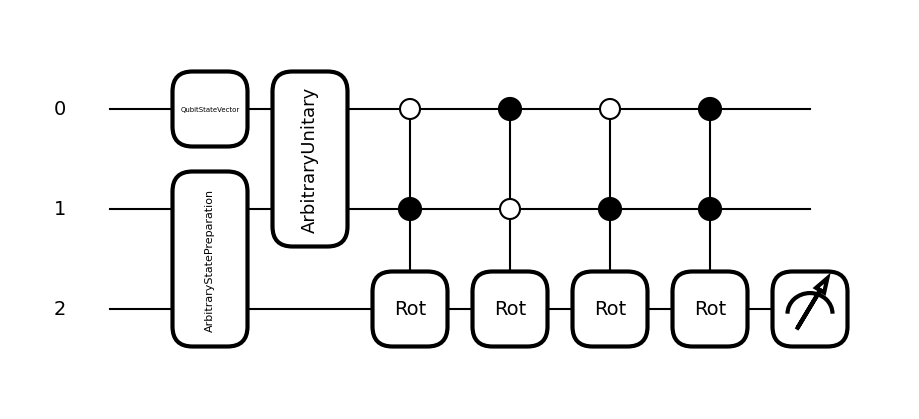

In [10]:
training_states = [
    np.array([1, 0]),
    np.array([1, 1]) / np.sqrt(2),
    np.array([1, -1]) / np.sqrt(2),
    np.array([1, 1j]) / np.sqrt(2),
]

teleport_ansatz = qnetvo.NetworkAnsatz(
    [input_prep_node(training_states[0]), entanglement_prep_node],
    [cc_sender_node],
    [cc_receiver_node],
)
init_settings = teleport_ansatz.rand_network_settings()

print("ideal ansataz")
@qml.qnode(qml.device("default.qubit", wires=[0,1,2]))
def draw_circ():
    teleport_ansatz.fn(teleport_ansatz.zero_network_settings())

    return qml.probs(wires=[2])

qml.draw_mpl(draw_circ)();

In [11]:
training_cost = cost_fn(training_states)
init_settings = teleport_ansatz.rand_network_settings()

# optimizing teleportation protocol
opt_dict = qnetvo.gradient_descent(
    training_cost,
    init_settings,
    step_size=1.6,
    num_steps=100,
    sample_width=1,
    verbose=True,
)

iteration :  0 , score :  0.574715821374834


/Users/brian/opt/anaconda3/envs/qnetvo-dev/lib/python3.8/site-packages/autograd/numpy/numpy_vjps.py:99: RuntimeWarning: divide by zero encountered in power
  defvjp(anp.sqrt,    lambda ans, x : lambda g: g * 0.5 * x**-0.5)
/Users/brian/opt/anaconda3/envs/qnetvo-dev/lib/python3.8/site-packages/autograd/numpy/numpy_wrapper.py:156: ComplexWarning: Casting complex values to real discards the imaginary part
  return A.astype(dtype, order, casting, subok, copy)


elapsed time :  0.2421109676361084
iteration :  1 , score :  0.6741508903601535
elapsed time :  0.3258848190307617
iteration :  2 , score :  0.7147653586159814
elapsed time :  0.3826422691345215
iteration :  3 , score :  0.7367457341577978
elapsed time :  0.3251619338989258
iteration :  4 , score :  0.7522069532536553
elapsed time :  0.3003511428833008
iteration :  5 , score :  0.7662704516133436
elapsed time :  0.38566112518310547
iteration :  6 , score :  0.7810467288701974
elapsed time :  0.4870889186859131
iteration :  7 , score :  0.7972447035167962
elapsed time :  0.6169209480285645
iteration :  8 , score :  0.8148939662973926
elapsed time :  0.24675321578979492
iteration :  9 , score :  0.8336330945543933
elapsed time :  0.22965693473815918
iteration :  10 , score :  0.8528724930295248
elapsed time :  0.4150807857513428
iteration :  11 , score :  0.8719052357492322
elapsed time :  0.2536351680755615
iteration :  12 , score :  0.8899631394992695
elapsed time :  0.4724018573760986

### 4. Testing Trained Teleportation Protocol

In [12]:
# generating 100 random states to test teleportation protocol
test_states = [unitary_group.rvs(2)[:, 0] for i in range(100)]
test_cost = cost_fn(test_states)

# np.isclose(test_cost(*opt_dict["opt_settings"]), -1, atol=5e-3)
test_score = - test_cost(*opt_dict["opt_settings"])

print("test score : ", test_score)

test score :  0.9997654028229307


Finally, we plot the gradient descent optimization and the test score to show how they compare.
Since the fidelity is maximal at value one, we use (1 - Average Fidelity) to measure closeness on a logscale

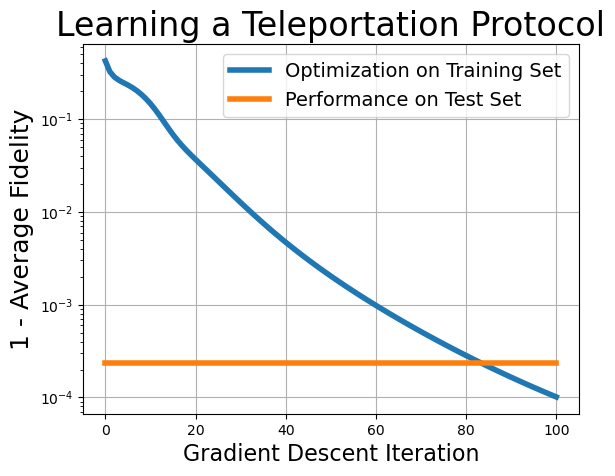

In [13]:
plt.semilogy(range(0,101), 1 - np.array(opt_dict["scores"]), label="Optimization on Training Set", linewidth=4)
plt.semilogy(range(0,101), 1 - np.array([test_score]*101), label="Performance on Test Set", linewidth=4)
plt.title("Learning a Teleportation Protocol", size=24)
plt.ylabel("1 - Average Fidelity", size=18)
plt.xlabel("Gradient Descent Iteration", size=16)
plt.grid()
plt.legend(fontsize=14)


# Training Entanglement Swapping Through a Bell Violation

### 1. Network Node Construction

In [14]:
ent_swap_prep_nodes = [
    qnetvo.PrepareNode(
        wires=[0,1],
        ansatz_fn=qnetvo.ghz_state,
    ),
    qnetvo.PrepareNode(
        wires=[2,3],
        ansatz_fn=qnetvo.ghz_state,
    ),
]

# noise on each source qubit
ent_swap_source_noise_nodes = [
    qnetvo.NoiseNode(wires=[0,4], ansatz_fn=lambda settings, wires: qnetvo.pure_amplitude_damping([0.1], wires=wires)),
    qnetvo.NoiseNode(wires=[1,5], ansatz_fn=lambda settings, wires: qnetvo.pure_phase_damping([0.2], wires=wires)),
    qnetvo.NoiseNode(wires=[2,6], ansatz_fn=lambda settings, wires: qnetvo.pure_phase_damping([0.1], wires=wires)),
    qnetvo.NoiseNode(wires=[3,7], ansatz_fn=lambda settings, wires: qnetvo.pure_amplitude_damping([0.2], wires=wires)),
]

# central node
def repeater_circ(settings, wires):
    qml.ArbitraryUnitary(settings, wires=wires[0:2])
    
    b0 = qml.measure(wires[0])
    b1 = qml.measure(wires[1])

    return [b0, b1]

ent_swap_repeater_node = [
    qnetvo.CCSenderNode(
        wires=[1,2],
        ansatz_fn=repeater_circ,
        num_settings=15,
        cc_wires_out=[0,1],
    )
]


# LOCC receiver
def ent_swap_cc_receiver_circ(settings, wires, cc_wires): 
    qml.cond(
        (cc_wires[0] == 0) & (cc_wires[1] == 1),
        qml.ArbitraryUnitary
    )(settings[0:3], wires=[wires[0]])
    qml.cond(
        (cc_wires[0] == 1) & (cc_wires[1] == 0),
        qml.ArbitraryUnitary
    )(settings[3:6], wires=[wires[0]])
    qml.cond(
        (cc_wires[0] == 0) & (cc_wires[1] == 1),
        qml.ArbitraryUnitary
    )(settings[6:9], wires=[wires[0]])
    qml.cond(
        (cc_wires[0] == 1) & (cc_wires[1] == 1),
        qml.ArbitraryUnitary
    )(settings[9:12], wires=[wires[0]])


ent_swap_receiver_node = [
    qnetvo.CCReceiverNode(
        wires=[3],
        cc_wires_in=[0,1],
        ansatz_fn=ent_swap_cc_receiver_circ,
        num_settings=12,
    )
]

ent_swap_meas_nodes = [
    qnetvo.MeasureNode(
        num_in=2,
        num_out=2,
        wires=[0],
        ansatz_fn=qml.ArbitraryUnitary,
        num_settings=3,
    ),
    qnetvo.MeasureNode(
        num_in=2,
        num_out=2,
        wires=[3],
        ansatz_fn=qml.ArbitraryUnitary,
        num_settings=3,
    ),
]

(<Figure size 1100x500 with 1 Axes>, <Axes: >)

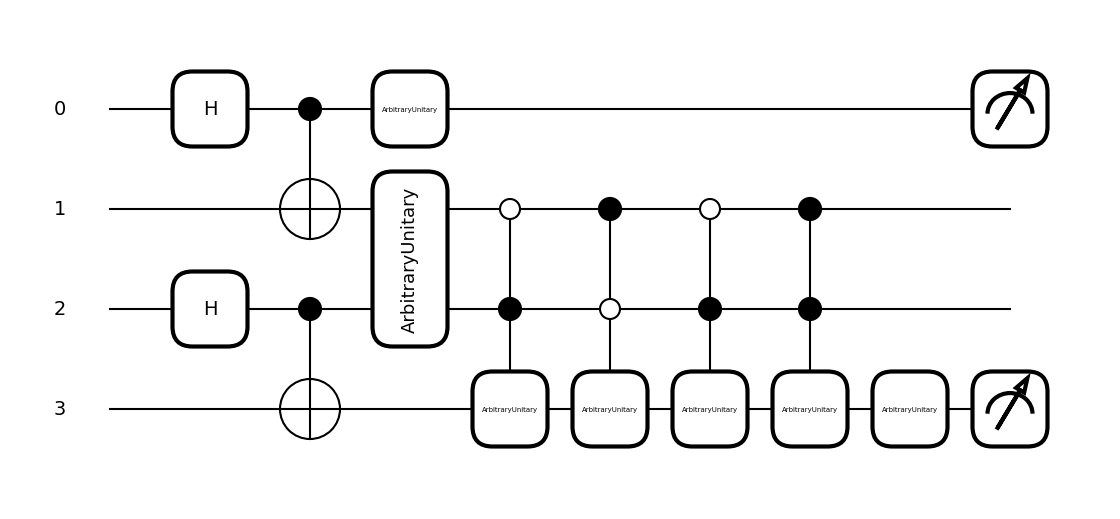

In [15]:
ideal_ent_swap_ansatz = qnetvo.NetworkAnsatz(
    ent_swap_prep_nodes,
    ent_swap_repeater_node,
    ent_swap_receiver_node,
    ent_swap_meas_nodes,
)

@qml.qnode(qml.device("default.qubit", wires=[0,1,2,3]))
def draw_circ():
    ideal_ent_swap_ansatz.fn(ideal_ent_swap_ansatz.zero_network_settings())

    return qml.probs(wires=[0,3])

qml.draw_mpl(draw_circ)()

(<Figure size 1600x900 with 1 Axes>, <Axes: >)

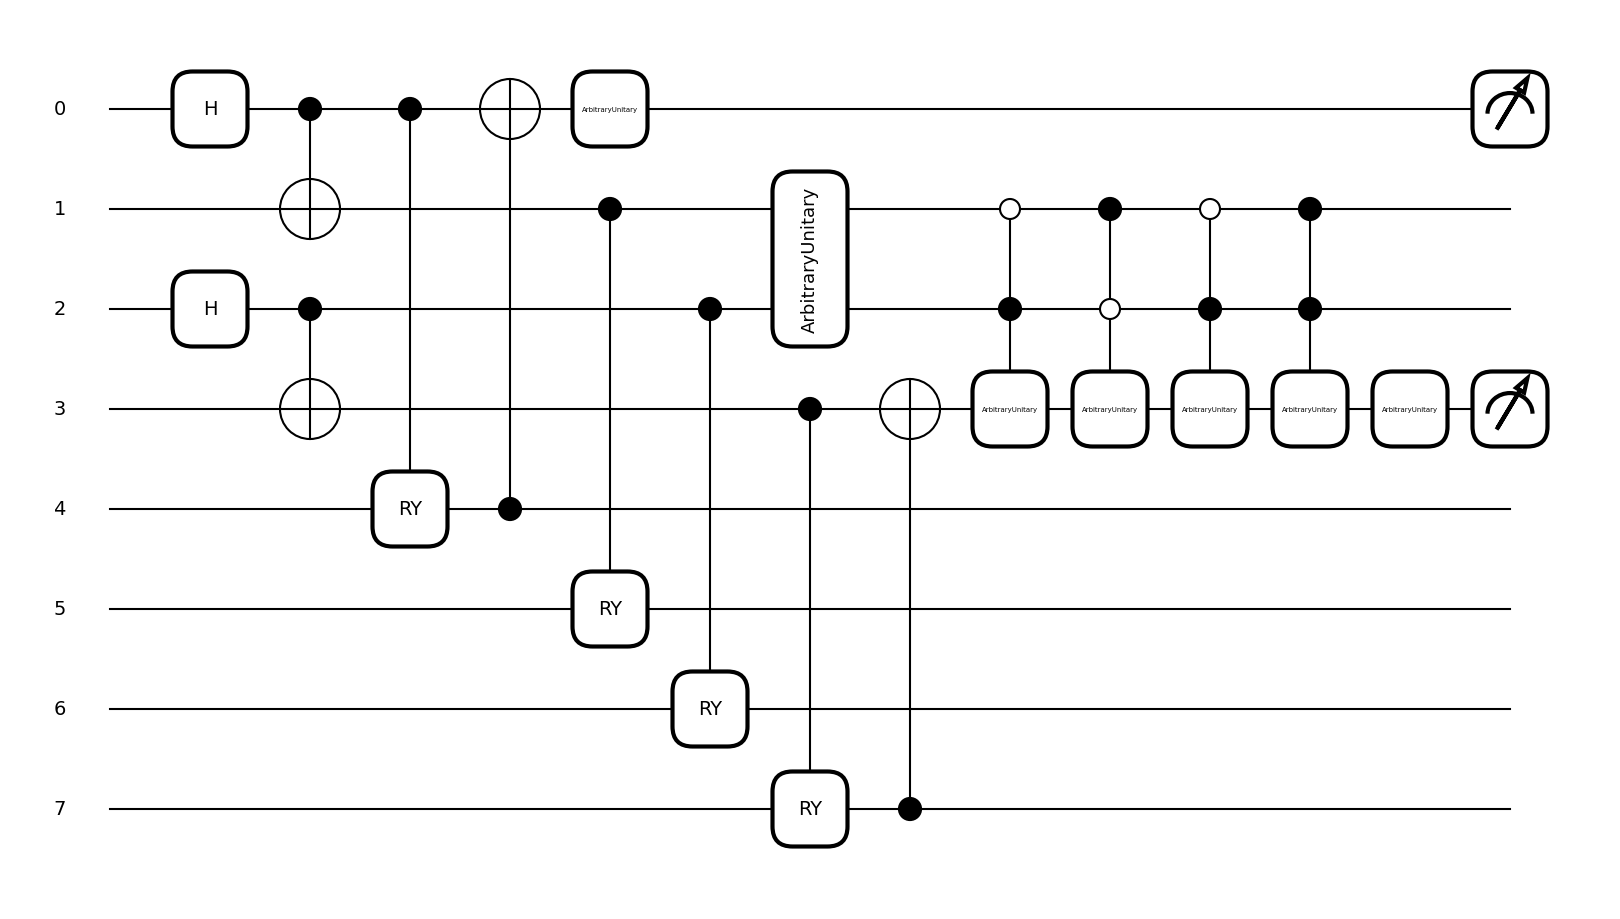

In [16]:
noisy_ent_swap_ansatz = qnetvo.NetworkAnsatz(
    ent_swap_prep_nodes,
    ent_swap_source_noise_nodes,
    ent_swap_repeater_node,
    ent_swap_receiver_node,
    ent_swap_meas_nodes,
)

@qml.qnode(qml.device("default.qubit", wires=[0,1,2,3,4,5,6,7]))
def draw_circ():
    noisy_ent_swap_ansatz.fn(noisy_ent_swap_ansatz.zero_network_settings())

    return qml.probs(wires=[0,3])

qml.draw_mpl(draw_circ)()

### Maximizing CHSH violation in Entanglement swapping

$$
    Cost(\Theta) = - S_{CHSH}(\Theta) = - \sum_{x,y\in\{0,1\}} (-1)^{xy}\langle A_{\vec{\theta}_x} B_{\vec{\theta}_y} \rangle_{\rho^{AB}_{\vec{\phi}}}
$$

In [17]:
noisy_chsh_cost = qnetvo.chsh_inequality_cost_fn(noisy_ent_swap_ansatz)
ideal_chsh_cost = qnetvo.chsh_inequality_cost_fn(ideal_ent_swap_ansatz)

In [18]:
np.random.seed(44)
ideal_ent_swap_opt_dict = qnetvo.gradient_descent(
    ideal_chsh_cost,
    ideal_ent_swap_ansatz.rand_network_settings(),
    verbose=True,
    sample_width=1,
    step_size=0.25,
    num_steps=80,
)

noisy_ent_swap_opt_dict = qnetvo.gradient_descent(
    noisy_chsh_cost,
    noisy_ent_swap_ansatz.rand_network_settings(),
    verbose=True,
    sample_width=1,
    step_size=0.25,
    num_steps=80,
)

iteration :  0 , score :  0.5629050814997851
elapsed time :  0.4540078639984131
iteration :  1 , score :  1.05979304840615
elapsed time :  0.3999321460723877
iteration :  2 , score :  1.3885932030102248
elapsed time :  0.25664806365966797
iteration :  3 , score :  1.588319184881591
elapsed time :  0.3889598846435547
iteration :  4 , score :  1.7149629321011746
elapsed time :  0.274627685546875
iteration :  5 , score :  1.7984693848240205
elapsed time :  0.32094788551330566
iteration :  6 , score :  1.8533817050847485
elapsed time :  0.2532341480255127
iteration :  7 , score :  1.8895659865604046
elapsed time :  0.47966885566711426
iteration :  8 , score :  1.9141044741415103
elapsed time :  0.25464701652526855
iteration :  9 , score :  1.931616588626531
elapsed time :  0.2690103054046631
iteration :  10 , score :  1.9448610006447153
elapsed time :  0.40854811668395996
iteration :  11 , score :  1.9554133088571346
elapsed time :  0.3114011287689209
iteration :  12 , score :  1.964175891

ideal settings noisy network :  1.9917510876992264
noisy optimum :  2.0722230063324423


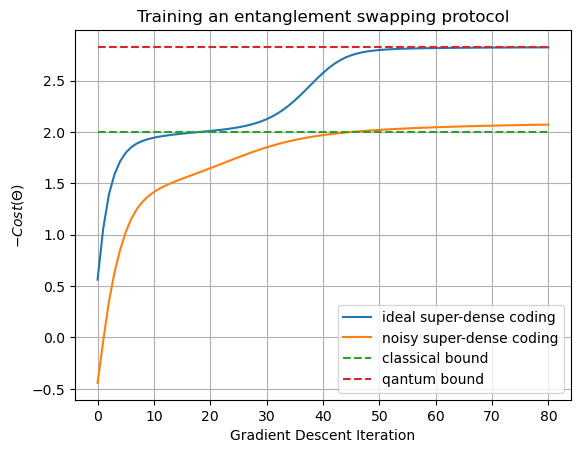

In [19]:
print("ideal settings noisy network : ", -noisy_chsh_cost(*ideal_ent_swap_opt_dict["opt_settings"]))
print("noisy optimum : ", noisy_ent_swap_opt_dict["opt_score"])

plt.plot(range(len(ideal_ent_swap_opt_dict["scores"])), ideal_ent_swap_opt_dict["scores"], label="ideal super-dense coding")
plt.plot(range(len(noisy_ent_swap_opt_dict["scores"])), noisy_ent_swap_opt_dict["scores"], label="noisy super-dense coding")
plt.plot(range(len(noisy_ent_swap_opt_dict["scores"])), [2]*len(noisy_ent_swap_opt_dict["scores"]), "--", label="classical bound")
plt.plot(range(len(noisy_ent_swap_opt_dict["scores"])), [2*qml.math.sqrt(2)]*len(noisy_ent_swap_opt_dict["scores"]), "--", label="qantum bound")

plt.grid()

plt.xlabel("Gradient Descent Iteration")
plt.ylabel(r"$-Cost(\Theta)$")
plt.legend()
plt.title("Training an entanglement swapping protocol")
plt.show()

## Star Network Entanglement Distribution

Consider the star network where $n$ external nodes $A_i$ each share an entangled state with a single central node $B$. If the central node performs a measurement in the GHZ basis (generalized Bell basis measurement) and communicates to each external node, one-bit of the measurement result, then the external nodes can use the received classical communication to reconstruct a desired GHZ state amongst the nodes. This protocol is a generalization of the entanglement swapping protocol. 

In [20]:
def star_prep_nodes(n):
    return [
        qnetvo.PrepareNode(wires=[i,n+i], ansatz_fn=qnetvo.ghz_state)
        for i in range(n)
    ]


def star_repeater_nodes(n):
    
    def star_repeater_ansatz(settings, wires):

        for i in range(1,n):
            qml.CNOT(wires=[wires[0],wires[i]]) 

        qml.Hadamard(wires=wires[0])

        measurements = []
        for i in range(n):
            measurements += [qml.measure(wires[i])]

        return measurements
    
    return [
        qnetvo.CCSenderNode(
            wires=range(n,2*n),
            cc_wires_out=range(n),
            ansatz_fn=star_repeater_ansatz,
        )
    ]


def star_receiver_nodes(n):

    def star_receiver_node_fn(settings, wires, cc_wires):
        for i in range(n):
            qml.cond(cc_wires[i] == 1, qml.ArbitraryUnitary)(settings[3*i:3*i+3], wires=[wires[0]])

    return [
        qnetvo.CCReceiverNode(
            wires=[i],
            cc_wires_in=range(n),
            ansatz_fn=star_receiver_node_fn,
            num_settings=3*n,
        )
        for i in range(1,n)
    ]



In [21]:
n=4

star_entanglement_distribution_ansatz = qnetvo.NetworkAnsatz(
    star_prep_nodes(n),
    star_repeater_nodes(n),
    star_receiver_nodes(n),
)

@qml.qnode(qml.device("default.qubit", wires=range(2*n)))
def star_teleportation(settings):
    star_entanglement_distribution_ansatz.fn(settings)

    return qml.density_matrix(wires=range(n))

def star_teleportation_cost_fn(n):
    def star_teleportation_cost(*settings):
        match_state = np.zeros((2**n,2**n))
        match_state[0,0] = 1/2
        match_state[2**n-1,2**n-1] = 1/2
        match_state[0,2**n-1] = 1/2
        match_state[2**n-1,0] = 1/2

        rho = star_teleportation(settings)


        return -1 * qml.math.fidelity(rho, match_state)
    
    return star_teleportation_cost

init_settings = star_entanglement_distribution_ansatz.rand_network_settings()
star_teleportation_opt_dict = qnetvo.gradient_descent(
    star_teleportation_cost_fn(n),
    init_settings,
    verbose=True,
    sample_width=1,
    step_size=1.5,
    num_steps=150,
)

iteration :  0 , score :  0.17184494982742296
elapsed time :  0.135145902633667


/Users/brian/opt/anaconda3/envs/qnetvo-dev/lib/python3.8/site-packages/autograd/numpy/numpy_vjps.py:99: RuntimeWarning: divide by zero encountered in power
  defvjp(anp.sqrt,    lambda ans, x : lambda g: g * 0.5 * x**-0.5)
/Users/brian/opt/anaconda3/envs/qnetvo-dev/lib/python3.8/site-packages/autograd/numpy/numpy_wrapper.py:156: ComplexWarning: Casting complex values to real discards the imaginary part
  return A.astype(dtype, order, casting, subok, copy)


iteration :  1 , score :  0.19096329858726102
elapsed time :  0.1054079532623291
iteration :  2 , score :  0.21221727106553892
elapsed time :  0.27670812606811523
iteration :  3 , score :  0.23479248876026987
elapsed time :  0.1014859676361084
iteration :  4 , score :  0.2576595014212362
elapsed time :  0.10187101364135742
iteration :  5 , score :  0.2799515405914124
elapsed time :  0.10413289070129395
iteration :  6 , score :  0.301168973338284
elapsed time :  0.10278797149658203
iteration :  7 , score :  0.3211556732248546
elapsed time :  0.1090548038482666
iteration :  8 , score :  0.3400178275739826
elapsed time :  0.10820627212524414
iteration :  9 , score :  0.35804149714128963
elapsed time :  0.10166096687316895
iteration :  10 , score :  0.3755910677656212
elapsed time :  0.10290813446044922
iteration :  11 , score :  0.39301282507841007
elapsed time :  0.10645508766174316
iteration :  12 , score :  0.4105746690163597
elapsed time :  0.10370898246765137
iteration :  13 , score 

/Users/brian/opt/anaconda3/envs/qnetvo-dev/lib/python3.8/site-packages/autograd/numpy/numpy_vjps.py:99: RuntimeWarning: invalid value encountered in power
  defvjp(anp.sqrt,    lambda ans, x : lambda g: g * 0.5 * x**-0.5)


iteration :  123 , score :  0.9999998223026817
elapsed time :  0.1018521785736084
iteration :  124 , score :  0.9999998445269391
elapsed time :  0.10281777381896973
iteration :  125 , score :  0.99999989210878
elapsed time :  0.10270094871520996
iteration :  126 , score :  0.9999999008748068
elapsed time :  0.10225677490234375
iteration :  127 , score :  0.9999999244201604
elapsed time :  0.10389304161071777
iteration :  128 , score :  0.9999999373295939
elapsed time :  0.10140180587768555
iteration :  129 , score :  0.9999999647552901
elapsed time :  0.10413193702697754
iteration :  130 , score :  0.999999966963131
elapsed time :  0.10260200500488281
iteration :  131 , score :  0.9999999866179081
elapsed time :  0.10063934326171875
iteration :  132 , score :  0.9999999964680915
elapsed time :  0.2688479423522949
iteration :  133 , score :  1.0000000060637237
elapsed time :  0.1355609893798828
iteration :  134 , score :  1.0000000092916657
elapsed time :  0.10124993324279785
iteration 

GHZ Distribution Fidelity :  0.9999999988490422


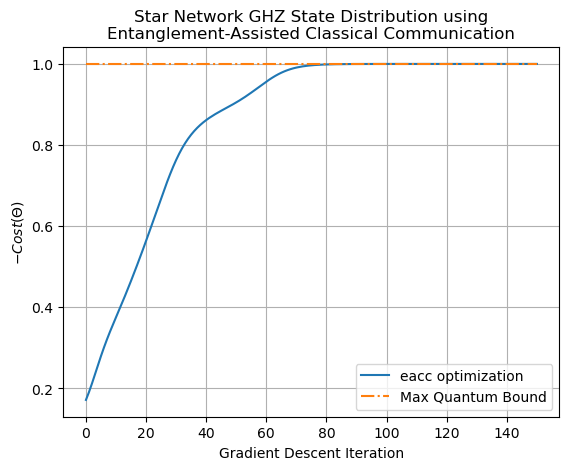

In [22]:
print("GHZ Distribution Fidelity : ", star_teleportation_opt_dict["opt_score"])

plt.plot(range(len(star_teleportation_opt_dict["scores"])), star_teleportation_opt_dict["scores"], label="eacc optimization")
# plt.plot(range(len(star_teleportation_opt_dict["scores"])), [6]*len(star_teleportation_opt_dict["scores"]), "--", label="classical bound")
plt.plot(range(len(star_teleportation_opt_dict["scores"])), [1]*len(star_teleportation_opt_dict["scores"]), "-.", label="Max Quantum Bound")

plt.grid()

plt.xlabel("Gradient Descent Iteration")
plt.ylabel(r"$-Cost(\Theta)$")
plt.legend()
plt.title("Star Network GHZ State Distribution using\nEntanglement-Assisted Classical Communication")
plt.show()

# Entanglement-Assisted Classical Communication

Here we train entanglement-assisted classical communication resources to maximize the score in a random access coding game.

In [23]:
eacc_prep_node = [
    qnetvo.PrepareNode(
        wires=[0,1],
        ansatz_fn=qnetvo.ghz_state,
    ),
]

def ea_encoder(settings, wires):

    qml.ArbitraryUnitary(settings, wires=wires)
    
    b0 = qml.measure(wires[0])

    return [b0]

ea_sender_node = [
    qnetvo.CCSenderNode(
        wires=[0],
        cc_wires_out=[0],
        num_in=4,
        ansatz_fn=ea_encoder,
        num_settings=3,
    ),
]

def ea_decoder(settings, wires, cc_wires):

    qml.cond(
        cc_wires[0] == 0,
        qml.ArbitraryUnitary,
    )(settings[0:3], wires=[wires[0]])

    qml.cond(
        cc_wires[0] == 1,
        qml.ArbitraryUnitary,
    )(settings[3:6], wires=[wires[0]])


ea_decoder_node = [
    qnetvo.CCReceiverNode(
        wires=[1],
        cc_wires_in=[0],
        num_in=2,
        num_settings=6,
        ansatz_fn=ea_decoder,
    )
]

ea_measure_node = [
    qnetvo.MeasureNode(
        wires=[1],
        num_out=2,        
    )
]
eacc_ansatz = qnetvo.NetworkAnsatz(
    eacc_prep_node,
    ea_sender_node,
    ea_decoder_node,
    ea_measure_node,
)

eacc_cost = qnetvo.linear_probs_cost_fn(
    eacc_ansatz,
    np.array([
        [1, 1, 1, 0, 0, 1, 0, 0],
        [0, 0, 0, 1, 1, 0, 1, 1],
    ]),
)
init_settings = eacc_ansatz.rand_network_settings()

eacc_opt_dict = qnetvo.gradient_descent(
    eacc_cost,
    init_settings,
    sample_width=1,
    step_size=0.8,
    num_steps=50,
    verbose=True,
)

iteration :  0 , score :  2.9103223109019796
elapsed time :  0.1968531608581543
iteration :  1 , score :  3.7935427228089096
elapsed time :  0.36488914489746094
iteration :  2 , score :  4.73548965018524
elapsed time :  0.38501405715942383
iteration :  3 , score :  5.581178665047339
elapsed time :  0.2827022075653076
iteration :  4 , score :  6.031064067692115
elapsed time :  0.2834341526031494
iteration :  5 , score :  6.13353954140348
elapsed time :  0.2674260139465332
iteration :  6 , score :  6.188685464062862
elapsed time :  0.3873417377471924
iteration :  7 , score :  6.243497677476973
elapsed time :  0.2934389114379883
iteration :  8 , score :  6.306167524270736
elapsed time :  0.22624778747558594
iteration :  9 , score :  6.382008571242914
elapsed time :  0.33461713790893555
iteration :  10 , score :  6.473318808672825
elapsed time :  0.24279189109802246
iteration :  11 , score :  6.574453417037267
elapsed time :  0.4778881072998047
iteration :  12 , score :  6.670271329795157


Game Score :  6.828035689673859


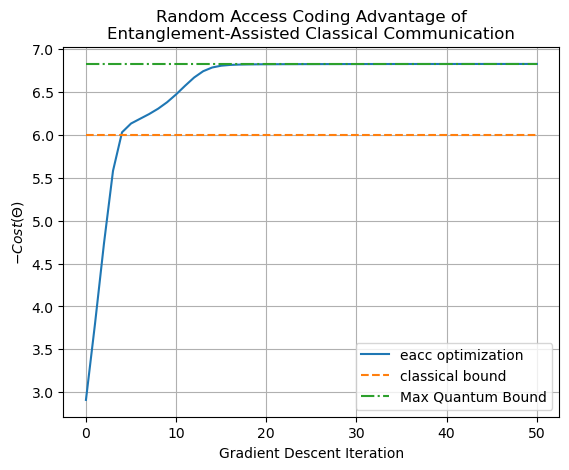

In [24]:
print("Game Score : ", eacc_opt_dict["opt_score"])

plt.plot(range(len(eacc_opt_dict["scores"])), eacc_opt_dict["scores"], label="eacc optimization")
plt.plot(range(len(eacc_opt_dict["scores"])), [6]*len(eacc_opt_dict["scores"]), "--", label="classical bound")
plt.plot(range(len(eacc_opt_dict["scores"])), [4 + 2*np.sqrt(2)]*len(eacc_opt_dict["scores"]), "-.", label="Max Quantum Bound")

plt.grid()

plt.xlabel("Gradient Descent Iteration")
plt.ylabel(r"$-Cost(\Theta)$")
plt.legend()
plt.title("Random Access Coding Advantage of\nEntanglement-Assisted Classical Communication")
plt.show()

## The Signaling Dimension of Entanglement-Assisted Classical Communication

In this section, we demonstrate that entanglement-assisted classical communication can improve the signaling dimension of a point-to-point communication setting. The details are described by [Frenkel and Weiner in 2020](https://quantum-journal.org/papers/q-2022-03-01-662/pdf/). 

In [25]:
# prepare a two-qubit maximally entangled state
eacc_prep_node = [
    qnetvo.PrepareNode(
        wires=[0,1],
        ansatz_fn=qnetvo.ghz_state
    ),
]

# create the sender's ansatz circuit 
def ea_encoder(settings, wires):

    qml.RY(settings[0], wires=[wires[2]])
    qml.ctrl(qml.SWAP, (wires[2]))(wires=wires[0:2])
    qml.ArbitraryUnitary(settings[1:4], wires=[wires[0]])
    
    b0 = qml.measure(wires[0])

    return [b0]

ea_sender_node = [
    qnetvo.CCSenderNode(
        wires=[0,2,3],
        cc_wires_out=[0],
        num_in=6,
        ansatz_fn=ea_encoder,
        num_settings=4,
    ),
]

# Measure Bob's qubit using a POVM conditioned on
# Alice's communicated measurement result
def ea_decoder(settings, wires, cc_wires):

    qml.cond(
        cc_wires[0] == 0,
        qml.ArbitraryUnitary,
    )(settings[0:15], wires=wires[0:2])
    qml.cond(
        cc_wires[0] == 1,
        qml.ArbitraryUnitary,
    )(settings[15:30], wires=wires[0:2])


ea_decoder_node = [
    qnetvo.CCReceiverNode(
        wires=[1,4],
        cc_wires_in=[0],
        num_in=1,
        num_settings=30,
        ansatz_fn=ea_decoder,
    )
]

ea_measure_node = [
    qnetvo.MeasureNode(
        wires=[1,4],
        num_out=4,        
    )
]
eacc_ansatz = qnetvo.NetworkAnsatz(
    eacc_prep_node,
    ea_sender_node,
    ea_decoder_node,
    ea_measure_node,
)

# creating a cost function encoding the game as a linear inequality
eacc_cost = qnetvo.linear_probs_cost_fn(
    eacc_ansatz,
    np.array([
        [0, 1, 1, 1, 0, 0],
        [1, 0, 1, 0, 1, 0],
        [1, 1, 0, 0, 0, 1],
        [0, 0, 0, 1, 1, 1],
    ])
)
init_settings = eacc_ansatz.rand_network_settings(fixed_setting_ids=[0,4,8,12,16,20],fixed_settings=[0,0,np.pi,0,0,np.pi])

eacc_opt_dict = qnetvo.gradient_descent(
    eacc_cost,
    init_settings,
    sample_width=1,
    step_size=0.8,
    num_steps=75,
    verbose=True,
)

iteration :  0 , score :  3.24185808780033
elapsed time :  0.8923330307006836
iteration :  1 , score :  3.7519560329368167
elapsed time :  1.1784288883209229
iteration :  2 , score :  4.0628830034527414
elapsed time :  1.0460669994354248
iteration :  3 , score :  4.295570112222522
elapsed time :  0.6567988395690918
iteration :  4 , score :  4.472035533015335
elapsed time :  0.9898109436035156
iteration :  5 , score :  4.602498179568608
elapsed time :  0.6418120861053467
iteration :  6 , score :  4.699701568277744
elapsed time :  1.1723270416259766
iteration :  7 , score :  4.773895001051434
elapsed time :  0.7726080417633057
iteration :  8 , score :  4.830815227259952
elapsed time :  0.9501810073852539
iteration :  9 , score :  4.873989970935168
elapsed time :  0.636422872543335
iteration :  10 , score :  4.906347861568118
elapsed time :  0.7846112251281738
iteration :  11 , score :  4.930420153452984
elapsed time :  0.5895230770111084
iteration :  12 , score :  4.948369371738257
elaps

Game Score :  5.414206701288915


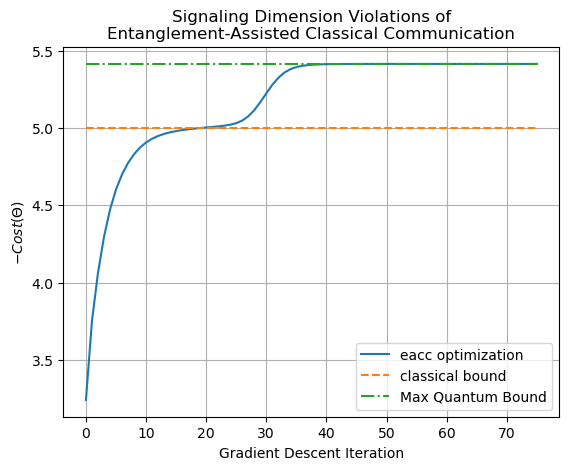

In [26]:
print("Game Score : ", eacc_opt_dict["opt_score"])

plt.plot(range(len(eacc_opt_dict["scores"])), eacc_opt_dict["scores"], label="eacc optimization")
plt.plot(range(len(eacc_opt_dict["scores"])), [5]*len(eacc_opt_dict["scores"]), "--", label="classical bound")
plt.plot(range(len(eacc_opt_dict["scores"])), [4 + 2/np.sqrt(2)]*len(eacc_opt_dict["scores"]), "-.", label="Max Quantum Bound")

plt.grid()

plt.xlabel("Gradient Descent Iteration")
plt.ylabel(r"$-Cost(\Theta)$")
plt.legend()
plt.title("Signaling Dimension Violations of\nEntanglement-Assisted Classical Communication")
plt.show()